<a href="https://colab.research.google.com/github/isratrimii/Machine-Learning/blob/main/Chess%20Classification%20Using%20CNN/chess_classification_using_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/bin/bash
!curl -L -o '/content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/chess.zip' https://www.kaggle.com/api/v1/datasets/download/anshulmehtakaggl/chess-pieces-detection-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3555k  100 3555k    0     0  5402k      0 --:--:-- --:--:-- --:--:-- 5402k


In [ ]:
!unzip '/content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/chess.zip' -d '/content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess'

Archive:  /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/chess.zip
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000000_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000001_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000003_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000004_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000005_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess/Queen-Resized/00000007_resized.jpg  
  inflating: /content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN

In [ ]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/COURSES/ML_CSE432_Lab/10 Image Classification using CNN/Chess'
img_size = (224, 224)
batch_size = 32
seed = 42

In [ ]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 651 files belonging to 5 classes.


In [ ]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [ ]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

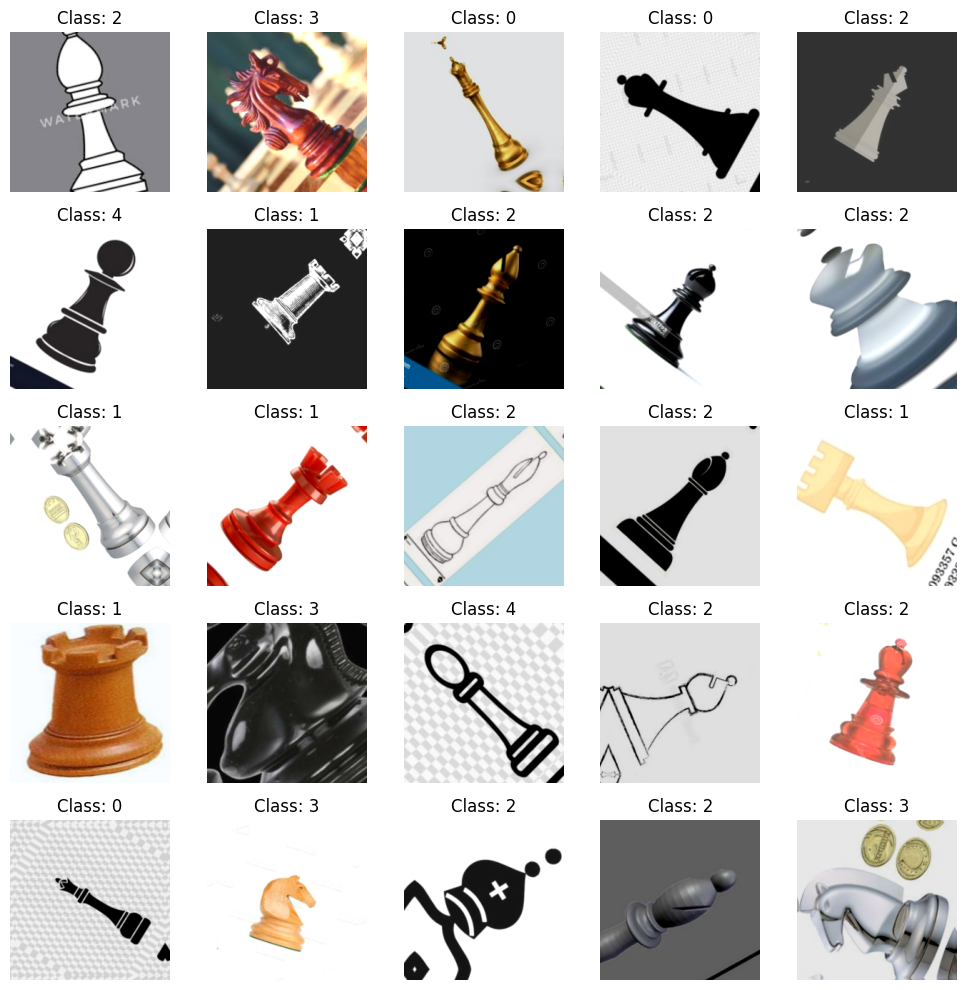

In [ ]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [ ]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,524,805 (24.89 MB)

 Trainable params: 6,524,805 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.2032 - loss: 2.8091
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2345 - loss: 1.6127
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - accuracy: 0.2322 - loss: 1.5978
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.2454 - loss: 1.5905
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.2199 - loss: 1.5939
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.2424 - loss: 1.5970
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.2553 - loss: 1.5773
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.2394 - loss: 1.5971
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.2476 - loss: 1.5949
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.2483 - loss: 1.5945


In [ ]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.2891 - loss: 1.5790
Test Accuracy: 0.30


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.2671 - loss: 31.8682
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.5957 - loss: 2.3691
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.6644 - loss: 1.0363
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.7243 - loss: 0.7695
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.7918 - loss: 0.6690
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - accuracy: 0.8470 - loss: 0.4864
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.8289 - loss: 0.5118
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.8074 - loss: 0.6630
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.8281 - loss: 0.5234
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.8353 - loss: 0.4875
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9011 - loss: 0.3555
Test Accuracy: 0.89


KeyError: 'val_accuracy'

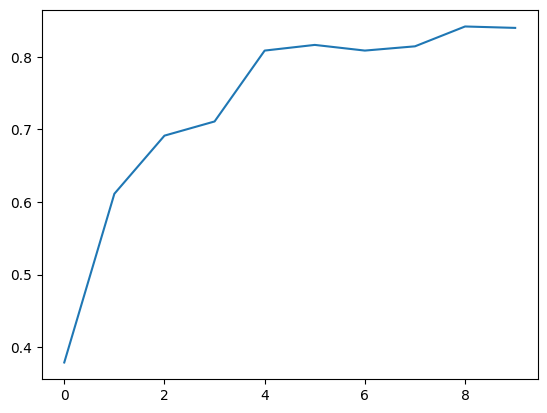

In [ ]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()
